<a href="https://colab.research.google.com/github/andrillion/Projects/blob/master/tail_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tail Assignment Problem


In [3]:
!apt-get install -y glpk-utils
!pip install -q pyomo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *

In [ ]:
# Definiera antalet flygplan och rutter
num_planes = 10
num_routes = 10

# Syntetisk kostnadsmatris för varje flygplan och rutt
# Kostnader i form av bränsle, underhåll och andra kostnader
np.random.seed(42)  # För reproducerbarhet
fuel_costs = np.random.randint(500, 1000, size=(num_planes, num_routes))
maintenance_costs = np.random.randint(200, 500, size=(num_planes, num_routes))
other_costs = np.random.randint(100, 300, size=(num_planes, num_routes))

# Total kostnadsmatris
total_costs = fuel_costs + maintenance_costs + other_costs

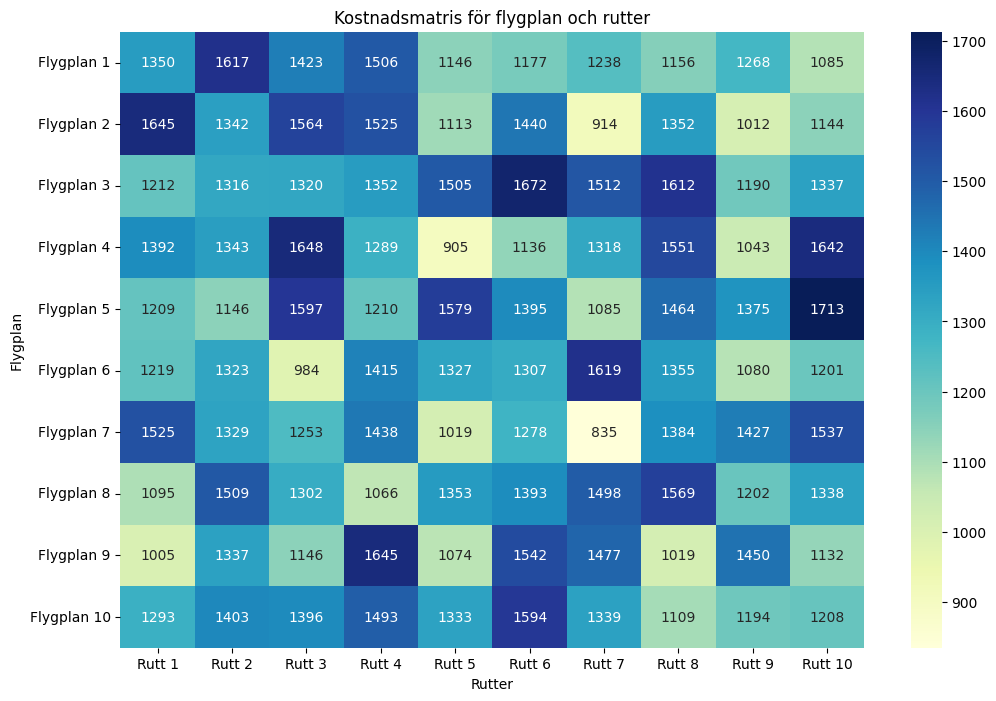

In [10]:
# Heatmap för kostnadsmatrisen
plt.figure(figsize=(12, 8))
sns.heatmap(total_costs, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=[f'Rutt {i+1}' for i in range(num_routes)],
            yticklabels=[f'Flygplan {i+1}' for i in range(num_planes)])
plt.title('Kostnadsmatris för flygplan och rutter')
plt.xlabel('Rutter')
plt.ylabel('Flygplan')
plt.show()

In [5]:
# Skapa en konkret modell för tilldelning
model = ConcreteModel()

# Beslutsvariabler: x[i,j] = 1 om flygplan i tilldelas rutt j, annars 0
model.x = Var(range(num_planes), range(num_routes), within=Binary)

# Objektivfunktion: Minimera den totala kostnaden
def objective_rule(model):
    return sum(total_costs[i, j] * model.x[i, j] for i in range(num_planes) for j in range(num_routes))
model.objective = Objective(rule=objective_rule, sense=minimize)

# Varje flygplan kan tilldelas exakt en rutt
def one_assignment_rule(model, i):
    return sum(model.x[i, j] for j in range(num_routes)) == 1
model.one_assignment = Constraint(range(num_planes), rule=one_assignment_rule)

# Varje rutt kan tilldelas exakt ett flygplan
def one_route_assignment_rule(model, j):
    return sum(model.x[i, j] for i in range(num_planes)) == 1
model.one_route_assignment = Constraint(range(num_routes), rule=one_route_assignment_rule)

# Lös problemet
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model)

# Hämta tilldelningarna
assignments = np.zeros((num_planes, num_routes))
for i in range(num_planes):
    for j in range(num_routes):
        assignments[i, j] = model.x[i, j]()

# Beräkna totala kostnader per rutt
total_route_costs = np.zeros(num_routes)
for j in range(num_routes):
    for i in range(num_planes):
        total_route_costs[j] += total_costs[i, j] * assignments[i, j]

# Beräkna delkostnader per rutt
fuel_cost_per_route = np.zeros(num_routes)
maintenance_cost_per_route = np.zeros(num_routes)
other_cost_per_route = np.zeros(num_routes)

for j in range(num_routes):
    for i in range(num_planes):
        fuel_cost_per_route[j] += fuel_costs[i, j] * assignments[i, j]
        maintenance_cost_per_route[j] += maintenance_costs[i, j] * assignments[i, j]
        other_cost_per_route[j] += other_costs[i, j] * assignments[i, j]

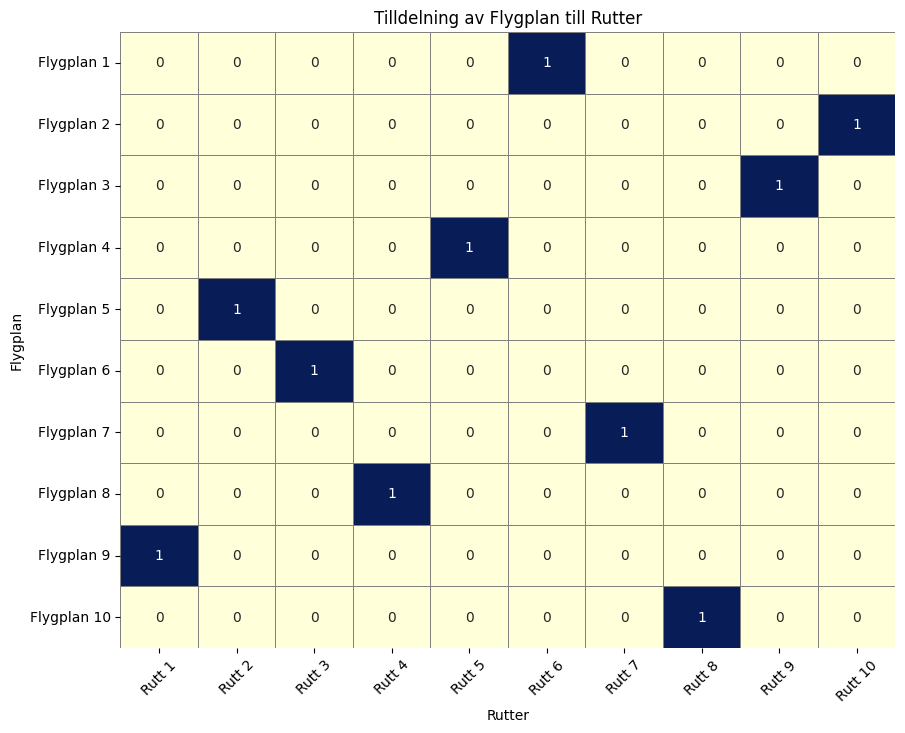

Total kostnad för allokeringen: 10561.00


In [12]:
# Visualisering av tilldelningen med heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(assignments, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Rutter')
plt.ylabel('Flygplan')
plt.title('Tilldelning av Flygplan till Rutter')
plt.xticks(ticks=np.arange(num_routes) + 0.5, labels=[f"Rutt {j+1}" for j in range(num_routes)], rotation=45)
plt.yticks(ticks=np.arange(num_planes) + 0.5, labels=[f"Flygplan {i+1}" for i in range(num_planes)], rotation=0)
plt.show()

# Skriv ut den totala kostnaden
total_cost = model.objective()
print(f'Total kostnad för allokeringen: {total_cost:.2f}')

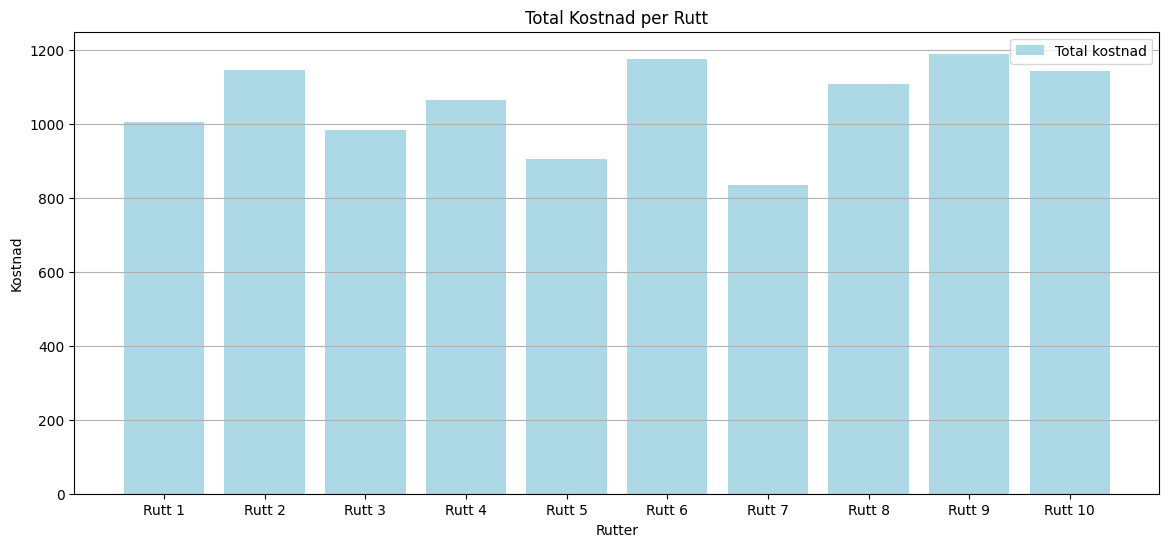

In [8]:
# Visualisering av totala kostnader per rutt
plt.figure(figsize=(14, 6))
plt.bar(range(num_routes), total_route_costs, color='lightblue', label='Total kostnad')
plt.xticks(range(num_routes), [f'Rutt {i+1}' for i in range(num_routes)])
plt.title('Total Kostnad per Rutt')
plt.xlabel('Rutter')
plt.ylabel('Kostnad')
plt.legend()
plt.grid(axis='y')
plt.show()

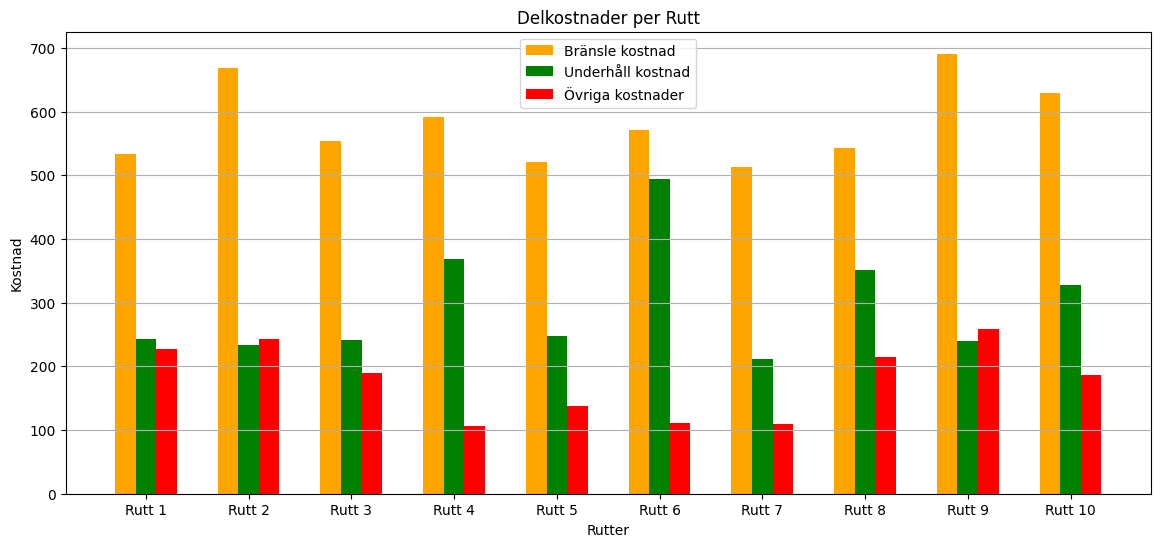

In [9]:
# Visualisering av delkostnader per rutt
bar_width = 0.2
x = np.arange(num_routes)

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width, fuel_cost_per_route, width=bar_width, label='Bränsle kostnad', color='orange')
plt.bar(x, maintenance_cost_per_route, width=bar_width, label='Underhåll kostnad', color='green')
plt.bar(x + bar_width, other_cost_per_route, width=bar_width, label='Övriga kostnader', color='red')

plt.xticks(x, [f'Rutt {i+1}' for i in range(num_routes)])
plt.title('Delkostnader per Rutt')
plt.xlabel('Rutter')
plt.ylabel('Kostnad')
plt.legend()
plt.grid(axis='y')
plt.show()

Optimerad kostnad: 10561.00
Slumpmässig kostnad: 12748.00
Förbättring: 2187.00


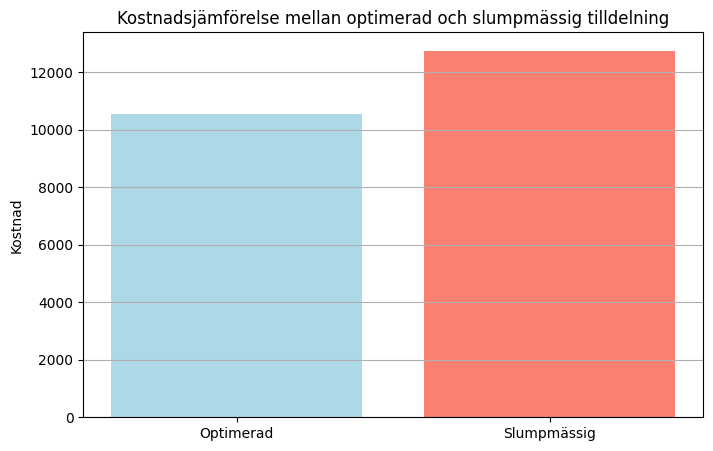

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *

# Definiera antalet flygplan och rutter
num_planes = 10
num_routes = 10

# Syntetisk kostnadsmatris för varje flygplan och rutt
np.random.seed(42)  # För reproducerbarhet
fuel_costs = np.random.randint(500, 1000, size=(num_planes, num_routes))
maintenance_costs = np.random.randint(200, 500, size=(num_planes, num_routes))
other_costs = np.random.randint(100, 300, size=(num_planes, num_routes))

# Total kostnadsmatris
total_costs = fuel_costs + maintenance_costs + other_costs

# Skapa en konkret modell för tilldelning
model = ConcreteModel()

# Beslutsvariabler: x[i,j] = 1 om flygplan i tilldelas rutt j, annars 0
model.x = Var(range(num_planes), range(num_routes), within=Binary)

# Objektivfunktion: Minimera den totala kostnaden
def objective_rule(model):
    return sum(total_costs[i, j] * model.x[i, j] for i in range(num_planes) for j in range(num_routes))
model.objective = Objective(rule=objective_rule, sense=minimize)

# Varje flygplan kan tilldelas exakt en rutt
def one_assignment_rule(model, i):
    return sum(model.x[i, j] for j in range(num_routes)) == 1
model.one_assignment = Constraint(range(num_planes), rule=one_assignment_rule)

# Varje rutt kan tilldelas exakt ett flygplan
def one_route_assignment_rule(model, j):
    return sum(model.x[i, j] for i in range(num_planes)) == 1
model.one_route_assignment = Constraint(range(num_routes), rule=one_route_assignment_rule)

# Lös problemet
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model)

# Hämta tilldelningarna
assignments = np.zeros((num_planes, num_routes))
for i in range(num_planes):
    for j in range(num_routes):
        assignments[i, j] = model.x[i, j]()

# Beräkna kostnaden för den optimerade tilldelningen
optimized_cost = model.objective()

# Slumptilldelning
def random_assignment(num_planes, num_routes):
    assignments_random = np.zeros((num_planes, num_routes))
    for j in range(num_routes):
        i = np.random.choice(range(num_planes))
        assignments_random[i, j] = 1
    return assignments_random

# Generera slumpmässig tilldelning
random_assignments = random_assignment(num_planes, num_routes)

# Beräkna kostnaden för den slumpmässiga tilldelningen
random_cost = sum(total_costs[i, j] * random_assignments[i, j] for i in range(num_planes) for j in range(num_routes))

# Jämför kostnader
print(f'Optimerad kostnad: {optimized_cost:.2f}')
print(f'Slumpmässig kostnad: {random_cost:.2f}')
print(f'Förbättring: {random_cost - optimized_cost:.2f}')

# Visualisera resultaten
labels = ['Optimerad', 'Slumpmässig']
costs = [optimized_cost, random_cost]

plt.figure(figsize=(8, 5))
plt.bar(labels, costs, color=['lightblue', 'salmon'])
plt.ylabel('Kostnad')
plt.title('Kostnadsjämförelse mellan optimerad och slumpmässig tilldelning')
plt.grid(axis='y')
plt.show()
